# Лабораторная работа №2 Введение в pytorch

### Вариант - 3

## Установка pytorch

In [1]:
import torch
import numpy as np

In [2]:
# numpy 

x = np.arange(16).reshape(4, 4)

print(f'X :\n {x}')
print(f'add 5 :\n {x + 5}')
print(f'X*X^T  :\n {np.dot(x, x.T)}')
print(f'mean over cols :\n {x.mean(axis=-1)}')
print(f'cumsum of cols :\n {np.cumsum(x, axis=0)}' )

X :
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
add 5 :
 [[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]
X*X^T  :
 [[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]
mean over cols :
 [ 1.5  5.5  9.5 13.5]
cumsum of cols :
 [[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]


In [3]:
# pytorch 

x = np.arange(16).reshape(4, 4)

x = torch.from_numpy(x).type(torch.FloatTensor) #или torch.arange(0,16).view(4,4)

print(f'X :\n {x}')
print(f'add 5 :\n {x + 5}')
print(f'X*X^T  :\n {torch.matmul(x, x.transpose(1, 0))}')
print(f'mean over cols :\n {torch.mean(x, dim=-1)}')
print(f'cumsum of cols :\n {torch.cumsum(x, dim=0)}')

X :
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
add 5 :
 tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T  :
 tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
mean over cols :
 tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols :
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


## NumPy vs Pytorch

Numpy и Pytorch не требуют описания статического графа вычислений.

Можно отлаживаться с помощью pdb или просто print.

API несколько различается:

In [4]:
# Определяем x с помощью torch.linspace
x = torch.linspace(0, 2 * np.pi, 16, dtype=torch.float64)

# Вычисляем sin(x) и cos(x)
sin_x = torch.sin(x)
cos_x = torch.cos(x)

# Вычисляем sin^2(x) и cos^2(x)
sin_squared = torch.pow(sin_x, 2)
cos_squared = torch.pow(cos_x, 2)

# Вычисляем sin^2(x) + cos^2(x)
out = sin_squared + cos_squared

print(out.numpy())

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Automatic gradients

У каждого тензора в Pytorch есть флаг `requires_grad`, который отвечает за автоматическое вычисление градиентов:

Создать переменную: `a = torch.tensor(..., requires_grad=True)`

Определить какую-нибудь дифференцируемую функцию `loss = whatever(a)`

Запросить обратный проход `loss.backward()`

Градиенты будут доступны в `a.grads`

Есть два важных отличия Pytorch от Theano/TF:

Функцию ошибки можно изменять динамически, например на каждом минибатче.

После вычисления `.backward()` градиенты сохраняются в `.grad` каждой задействованной переменной, при повторных вызовах градиенты суммируются. Это позволяет использовать несколько функций ошибок или виртуально увеличивать batch_size. Поэтому, после каждого шага оптимизатора градиенты стоит обнулять.

## Leaf vs Non-leaf Variable:

In [5]:
x = torch.tensor([1., 2., 3., 4.], requires_grad=True)  # leaf tensor
y = x + 1  # not a leaf variable

Градиенты будут сохранены и доступны для использования только для `leaf tensor`. Такое поведение по-умолчанию сделано ради экономии памяти. Все тензоры с флагом `requires_grad = False` считаются `leaf tensors` по умолчанию.

Обратим внимание, что вычисление градиентов работает только для тензоров с вещественным типом данных:

Чтобы выставить флаг `requires_grad=False` и выключить автоматическое вычисление градиентов для нескольких тензоров, можно использовать `with torch.no_grad()` или `detach`:

In [6]:
x = torch.tensor([1.], requires_grad=True)
y = x**2
print(x.requires_grad)
print(y.requires_grad)

with torch.no_grad():
    z = torch.exp(x)
    print(z.requires_grad)
    
# отсоединимся от графика
w = torch.log(x).detach()
print(w.requires_grad)

True
True
False
False


## Пример линейной регрессии на датасете California

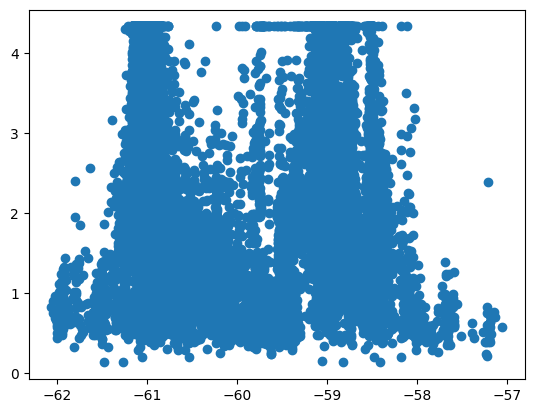

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

#для простоты выберем один столбец
x = X[:, -1] / X[:, -1].std()
y = y / y.std()

plt.scatter(x, y);

In [8]:
# модельные тензоры
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# тензоры данных
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# все тензоры являются leaf-tensors
# x и y не требуют вычисления градиентов
for vv in [w, b, x, y]:
    print(vv.is_leaf, vv.requires_grad)

True True
True True
True False
True False


In [9]:
#попробуем градиенты
y_pred = w * x + b
loss = torch.mean((y_pred - y)**2)

loss.backward()

#теперь w.grad - это тензор, содержащий градиент L w.r.t. w

print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)

# нет градиентов для тензоров с requires_grad=False
# и non-leaf tensors
print("Non-Leaf x dL/dx = \n", x.grad)
print("Non-Leaf loss dL/dpred = \n", y_pred.grad)

dL/dw = 
 tensor([214.0627])
dL/db = 
 tensor([-3.5852])
Non-Leaf x dL/dx = 
 None
Non-Leaf loss dL/dpred = 
 None


C:\Users\maksi\AppData\Local\Temp\ipykernel_13132\785956107.py:15: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  print("Non-Leaf loss dL/dpred = \n", y_pred.grad)


## Градиенты промежуточных вершин

В графе, который мы описали `x` и `y_pread` не являются листовыми вершинами. По умолчанию для них не сохраняются градиенты.

Для промежуточных вершин мы можем запросить сохранение градиентов с помощью функции `.retain_grad()`.

In [10]:
y_pred = w * x + b

# проверим это:
y_pred.retain_grad()

loss = torch.mean((y_pred - y)**2)
loss.backward()

print("Non-Leaf loss dL/dpred = \n", y_pred.grad[:10])

Non-Leaf loss dL/dpred = 
 tensor([-0.0004, -0.0003, -0.0003, -0.0003, -0.0003, -0.0002, -0.0003, -0.0002,
        -0.0002, -0.0002])


## Линейная регрессия

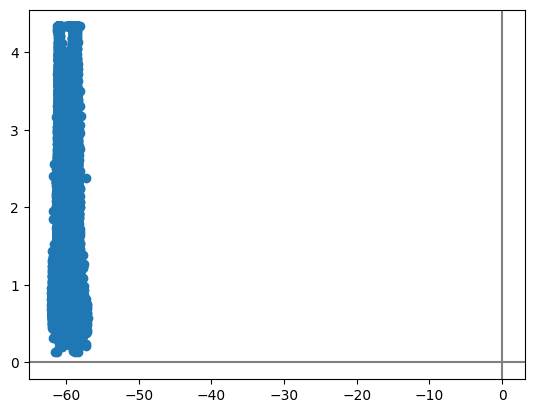

loss =  nan


In [11]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Предполагая, что мы определили свои данные (x, y) и инициализировали свои параметры (w, b)

for i in range(100):
    
    # Вычислительные потери
    y_pred = w * x  + b
    loss = torch.mean((y_pred - y)**2)
    
    # Обратное распространение
    loss.backward()
    
    # Шаг градиентного спуска для весов и смещения
    with torch.no_grad():
        w -= 0.1 * w.grad
        b -= 0.1 * b.grad
    
    # Нулевые градиенты
    w.grad.zero_()
    b.grad.zero_()
    
    # Остальная часть кода предназначена только для визуализации
    if (i + 1) % 5 == 0:
        # Составим прогноз линейной регрессии на основе данных
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(), y.numpy())
        plt.plot(x.numpy(), y_pred.data.numpy(), color='orange')
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break

## Оптимизаторы

В этом примере мы пользовались простым правилом для градиентного спуска:
$$\theta^{n+1} = \theta^{n} - \alpha \nabla_{\theta}L$$

Единственным параметром в нем является 
$\alpha$ -- это `learning_rate`.

На практике часто используют различные модификации (например Momentum):
$$\theta^{n+1} = \theta^{n} - U^{n}U^{n} = \gamma U^{n-1} + \alpha \nabla_{\theta}(L)
$$

Pytorch предоставляет практически все широкораспространненные оптимизаторы:
http://pytorch.org/docs/master/optim.html

Оптимизаторы удобны в использовании:

- требуется указать список переменных для оптимизации
- `opt.step()` применяет `update` ($U^{n}$) к весам
- `opt.zero_grad()` сбрасывает градиенты

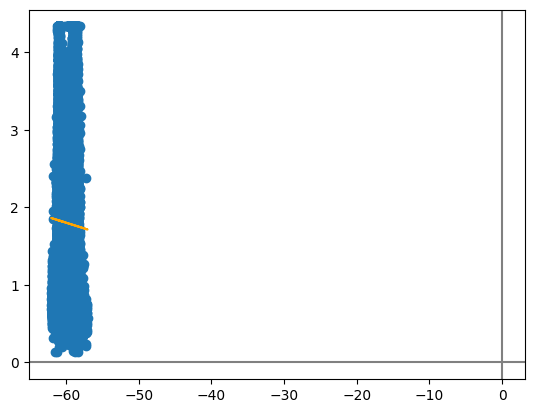

loss =  0.9981564283370972


In [12]:
# получение данных
x, y = fetch_california_housing(return_X_y=True)
x = x[:, -1] / x[:, -1].std()
y = y / y.std()

# тензоры данных
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# модельные тензоры
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# определим оптимизатор
opt = torch.optim.RMSprop([w, b], lr=0.1)

for i in range(100):
    # Вычислим прогнозы
    y_pred = w * x + b
    
    # Потери при вычислении (среднеквадратичная ошибка)
    loss = torch.mean((y_pred - y)**2)
    
    # Обратное распространение и градиентный спуск
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # Остальная часть кода предназначена для визуализации
    if (i + 1) % 5 == 0:
        # Составим прогноз линейной регрессии на основе данных
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(), y.numpy())
        plt.plot(x.numpy(), y_pred.data.numpy(), color='orange')
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break

## Высокоуровневые API

При работе с нейронными сетями становится неудобно контролировать переменные с весами по-отдельности. Pytorch предоставляет высокоуровневый API для моделей http://pytorch.org/docs/master/nn.html#torch.nn.Module.

Чтобы воспользоваться моделью необходимо отнаследоваться от torch.nn.Module, определить слои и описать `forward`, `backward` будет вычислен автоматически.

Для демонстрации снова воспользуемся MNIST'ом.

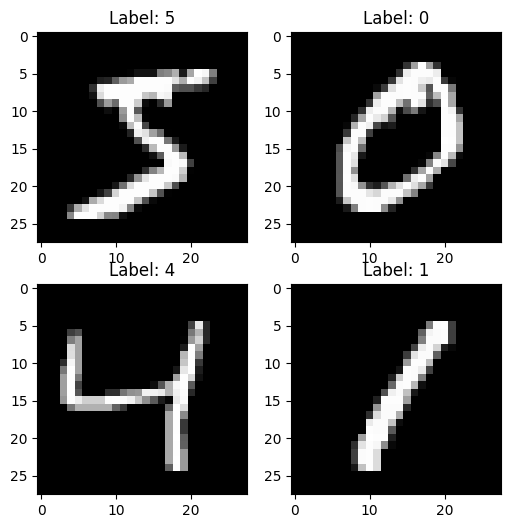

In [13]:
# MNIST 
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title(f"Label: {y_train[i]}")
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

In [14]:
# Более высокий уровень API:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, hidden_size=40):
        super(Net, self).__init__()
        # здесь мы создаем веса для слоев
        self.fc1 = nn.Linear(X_train.shape[1], hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
        
    def forward(self, x):
        # здесь мы описываем использование слоев
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # проверим подпись log_softmax
        return F.log_softmax(x, dim=-1)
    # обратная функция вычисляет автоматически

In [15]:
# интерфейс модели:
model = Net()
tt = torch.from_numpy(X_train[:10, :].astype(np.float32))
output = model(tt)

print('Model outputs: \n', output)
# TODO: получите вероятности из output c помощью функций из torch
# hint: см документацию к log_softmax
probs = torch.nn.functional.log_softmax(output, dim=1)
print('Probs: \n', probs)

# TODO: получите предсказание из output c помощью функций из torch
pred = torch.argmax(output, dim=1)
print('Pred: \n', pred.data.numpy())
print('Truth: \n', y_train[:10])

Model outputs: 
 tensor([[-2.1911, -2.4077, -2.3080, -2.3826, -2.3040, -2.4744, -2.2624, -2.1736,
         -2.2259, -2.3382],
        [-2.2069, -2.4039, -2.3418, -2.3824, -2.2865, -2.4627, -2.2517, -2.1782,
         -2.2241, -2.3263],
        [-2.2505, -2.4104, -2.3430, -2.3553, -2.2949, -2.4679, -2.2291, -2.2236,
         -2.1689, -2.3199],
        [-2.2522, -2.4215, -2.3350, -2.3609, -2.2986, -2.4399, -2.2581, -2.2139,
         -2.1921, -2.2845],
        [-2.2445, -2.4139, -2.3334, -2.3846, -2.2944, -2.4519, -2.2493, -2.1880,
         -2.1893, -2.3137],
        [-2.1965, -2.3799, -2.3287, -2.3741, -2.3016, -2.4964, -2.2645, -2.1958,
         -2.2115, -2.3170],
        [-2.2291, -2.4209, -2.3530, -2.3801, -2.3112, -2.4494, -2.2563, -2.1590,
         -2.1934, -2.3156],
        [-2.1971, -2.4229, -2.3287, -2.3932, -2.2708, -2.4843, -2.2467, -2.1779,
         -2.2243, -2.3262],
        [-2.2552, -2.4038, -2.3527, -2.3602, -2.3225, -2.4462, -2.2531, -2.1806,
         -2.1789, -2.3085],
  

Тренировка сети

Для тренировки сети нам требуется

- итератор по данным
- функция тренировки (прогон по данным, вычисление и применение градиентов)
- функция валидации (прогон по тестовым данным, вычисление метрик)

In [16]:
from IPython.display import clear_output
from tqdm.auto import tqdm

# функция для итераций по минибатчам
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [17]:
def train(model, optimizer, batchsize=32):
    loss_log = []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log


# TODO: написать функцию для валидации по X_val, y_val
# hint: optimizer не нужен
def test(model):
    loss_log = []
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(X_val.astype(np.float32))
        target = torch.from_numpy(y_val.astype(np.int64))
        output = model(data)
        loss = F.nll_loss(output, target)
        loss_log.append(loss.item())
    
    return loss_log

In [18]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    epochs = len(train_history)
    plt.plot(range(1, epochs + 1), train_history, label='Train')
    plt.plot(range(1, epochs + 1), val_history, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.title(title + ' vs Epoch')
    plt.legend()
    plt.show()

  0%|          | 0/1562 [00:00<?, ?it/s]

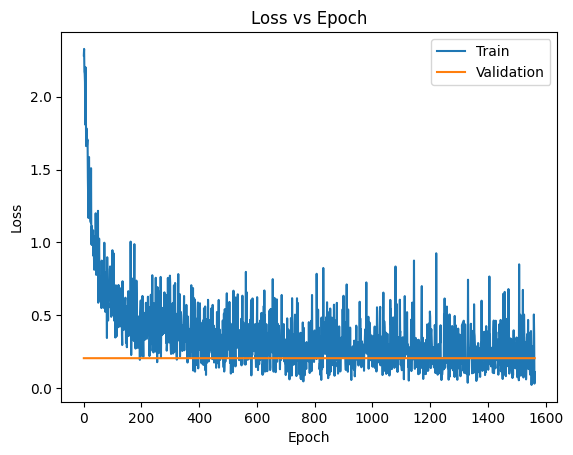

  0%|          | 0/1562 [00:00<?, ?it/s]

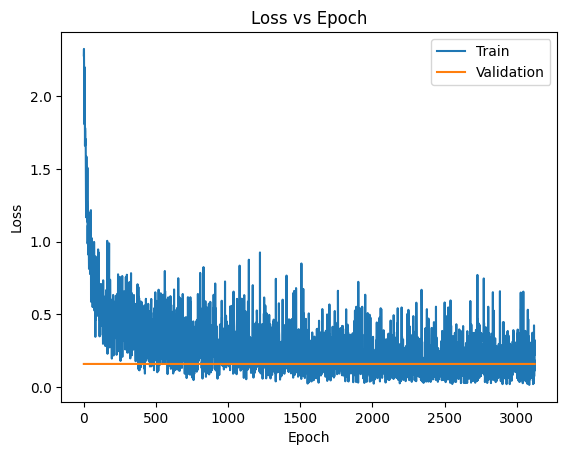

  0%|          | 0/1562 [00:00<?, ?it/s]

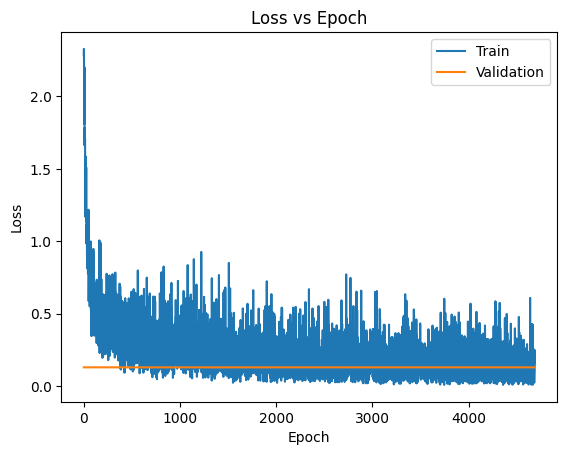

  0%|          | 0/1562 [00:00<?, ?it/s]

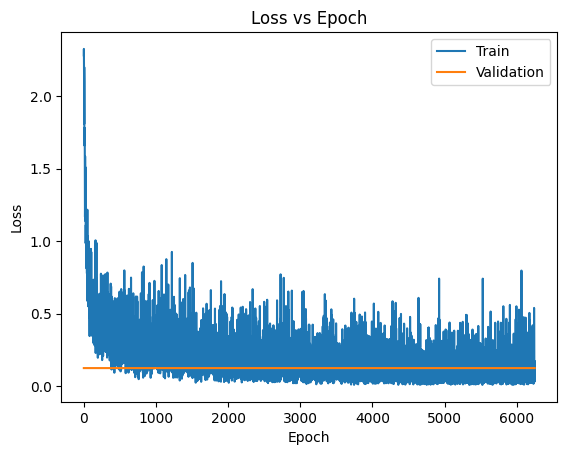

  0%|          | 0/1562 [00:00<?, ?it/s]

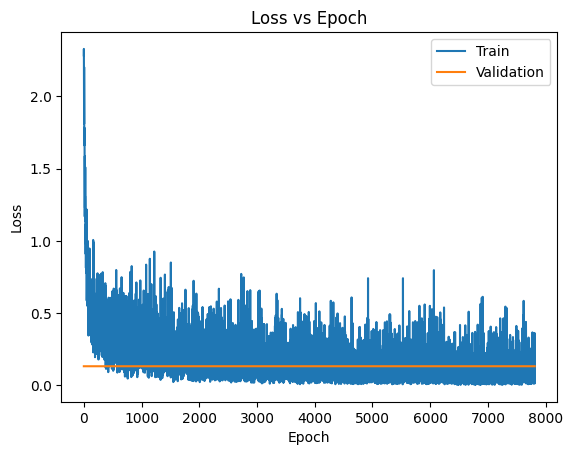

  0%|          | 0/1562 [00:00<?, ?it/s]

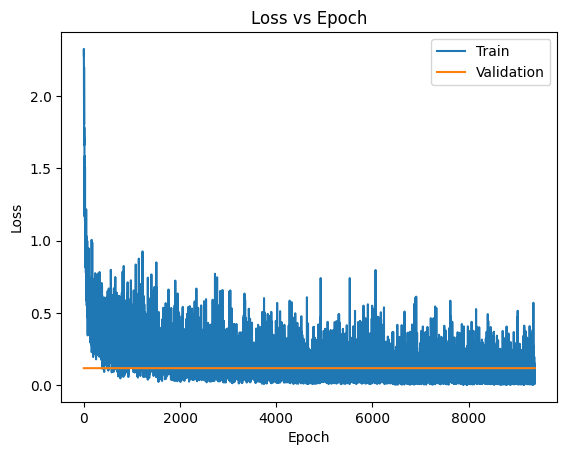

  0%|          | 0/1562 [00:00<?, ?it/s]

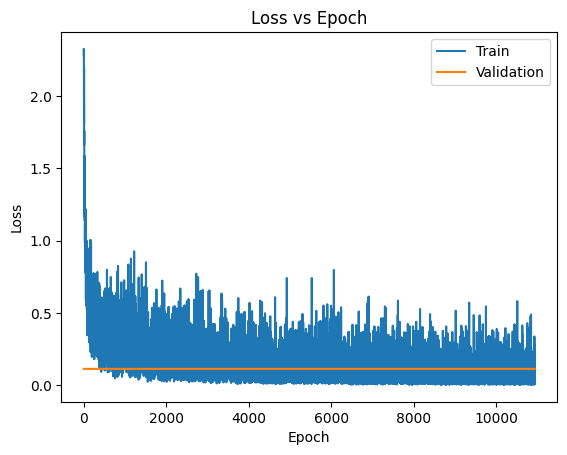

  0%|          | 0/1562 [00:00<?, ?it/s]

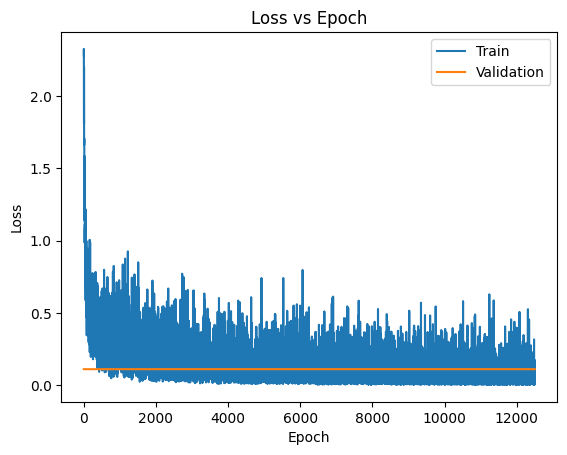

  0%|          | 0/1562 [00:00<?, ?it/s]

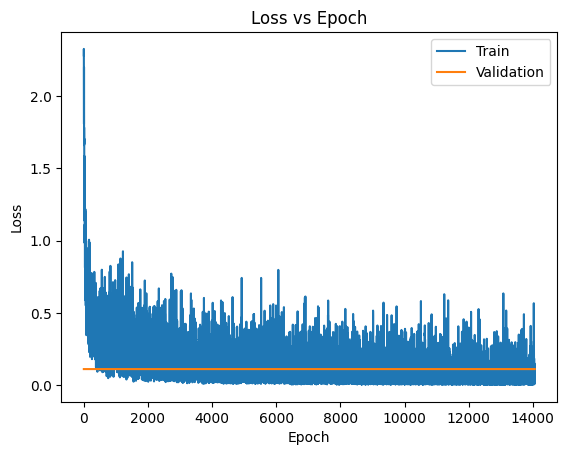

  0%|          | 0/1562 [00:00<?, ?it/s]

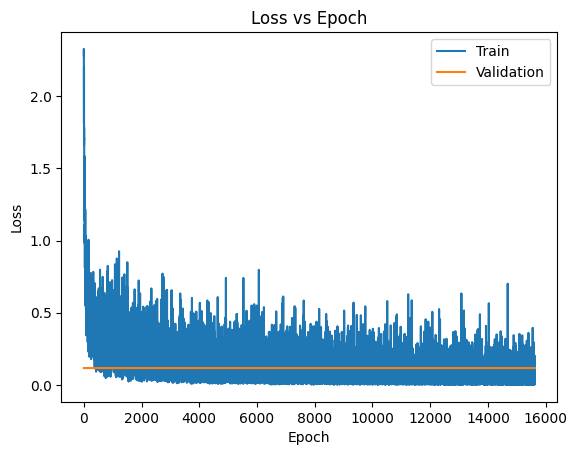

In [19]:
train_log = []
val_log = []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32

for epoch in range(10):
    train_loss = train(model, opt, batchsize=batchsize)
    train_log.extend(train_loss)
    
    val_loss = np.mean(test(model))
        
    # TODO: график train_loss vs train_steps с точками val_loss vs trained_steps
    val_log.append(val_loss)
    # используем свой plot_history()
    plot_history(train_log, [val_loss]*len(train_log), title='Loss')
    # hint: train_log и val_log может содержать данные различной формы

## Метрики

Logloss - величина, которую трудно интерпретировать. Для отслеживания тренировки и сравнения моделей удобнее наблюдать за интерпретируемыми метриками, например точностью (accuracy)

Модифицируем код train/test функций так, чтобы помимо ошибки подсчитывалась точность за батч:

Epoch 10
Train loss: 0.05780750870230344, Train accuracy: 0.9813740396927016
Val loss: [0.13554976880550385, 0.00308101624250412, 0.4045422077178955, 0.06998804956674576, 0.013327923603355885, 0.053935568779706955, 0.29231762886047363, 0.1740751713514328, 0.005889974534511566, 0.04158971086144447, 0.5181176662445068, 0.07065779715776443, 0.3567522168159485, 0.4173460006713867, 0.03018621727824211, 0.22273437678813934, 0.7618038058280945, 0.36505967378616333, 0.0070710564032197, 0.015995802357792854, 0.024919036775827408, 0.017119234427809715, 0.1073996052145958, 0.20497000217437744, 0.08301590383052826, 0.03901316225528717, 0.029093915596604347, 0.003889295272529125, 0.04110708087682724, 0.031656552106142044, 0.03504793718457222, 0.003742394270375371, 0.05127419903874397, 0.05881980061531067, 0.0078458022326231, 0.008434820920228958, 0.036227427423000336, 0.04075224697589874, 0.023948967456817627, 0.18575814366340637, 0.25144723057746887, 0.01955575868487358, 0.01526724360883236, 0.032

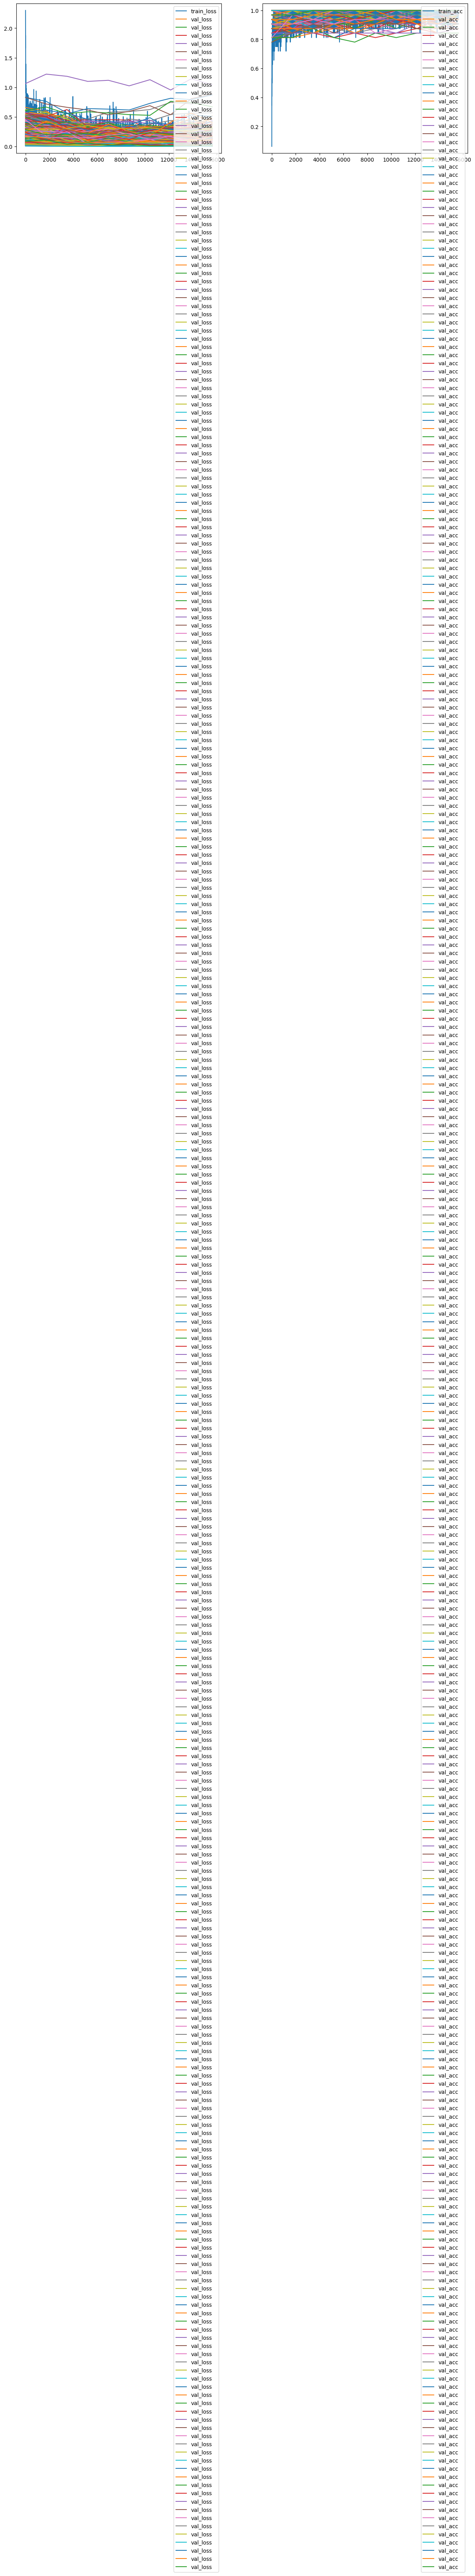

In [20]:
def train(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(output, dim=1)
        accuracy = torch.mean((preds == target).float())
        
        loss_log.append(loss.item())
        acc_log.append(accuracy.item())
    
    return loss_log, acc_log


def test(model):
    loss_log, acc_log = [], []
    
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=False):
            data = torch.from_numpy(x_batch.astype(np.float32))
            target = torch.from_numpy(y_batch.astype(np.int64))
            
            output = model(data)
            loss = F.nll_loss(output, target)
            
            preds = torch.argmax(output, dim=1)
            accuracy = torch.mean((preds == target).float())
            
            loss_log.append(loss.item())
            acc_log.append(accuracy.item())
    
    return loss_log, acc_log



def plot_history(loss_log, acc_log, val_loss_log, val_acc_log):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_log, label='train_loss')
    plt.plot(np.linspace(0, len(loss_log), len(val_loss_log)), val_loss_log, label='val_loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(acc_log, label='train_acc')
    plt.plot(np.linspace(0, len(acc_log), len(val_acc_log)), val_acc_log, label='val_acc')
    plt.legend()
    
    plt.show()


train_log, train_acc_log = [], []
val_log, val_acc_log = [], []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32


for epoch in range(10):
    train_loss, train_acc = train(model, opt, batchsize=batchsize)
    val_loss, val_acc = test(model)
    
    train_log.extend(train_loss)
    train_acc_log.extend(train_acc)
    val_log.append(val_loss)
    val_acc_log.append(val_acc)
    
    clear_output(wait=True)
    print(f"Epoch {epoch+1}")
    print(f"Train loss: {np.mean(train_loss)}, Train accuracy: {np.mean(train_acc)}")
    print(f"Val loss: {val_loss}, Val accuracy: {val_acc}")
    plot_history(train_log, train_acc_log, val_log, val_acc_log)

Загрузчик данных -- одна из важных компонент для эффективного обучения нейронных сетей: асинхронная загрузка и быстрая предобработка важны для полного использования GPU. В pytorch для этого есть https://pytorch.org/docs/stable/data.html

## Пример использования загрузчика данных:

In [3]:
%matplotlib inline

import time
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()
plt.ion()

<font color='red'>ЕСЛИ ПОЯВЛЯЕТСЯ ОШИБКА:</font> 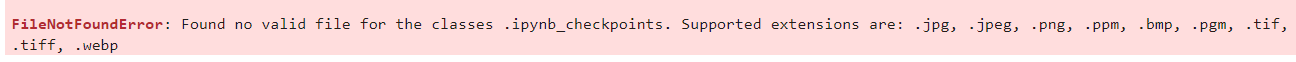
<font color='red'>ТО НУЖНО УДАЛИТЬ В ПРОВОДНИКЕ ДАННЫЕ ФАЙЛЫ, В УКЗАННОЙ ДИРЕКТОРИИ</font>

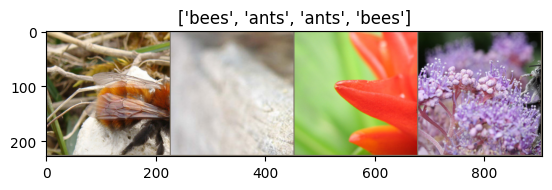

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.1)  # сделаем небольшую паузу, чтобы графики обновились


# Получим пакет обучающих данных
inputs, classes = next(iter(dataloaders['train']))

# Сделаем сетку из пакета
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
# обратим внимание на сохранение лучшей версии весов сети
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Каждая эпоха имеет этап обучения и валидации
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Переведем модель в режим обучения
            else:
                model.train(False)  # Установим модель для оценки модели

            running_loss = 0.0
            running_corrects = 0

            # Выполним итерацию по данным.
            for data in dataloaders[phase]:
                # получим исходные данные
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # обнулим градиенты параметров
                optimizer.zero_grad()

                # вперед
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # обратная оптимизация + только в том случае, если она находится на этапе обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).type(torch.float)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # глубокое копирование модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        time_elapsed = time.time() - since
        print('Elapsed {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса моделей
    model.load_state_dict(best_model_wts)
    return model

In [8]:
# torchvision содержит ряд моделей с претрейненными весами:
[m for m in dir(models) if not m.startswith('_')]

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [10]:
model_ft = models.resnet18(pretrained=True)
# hint: вы можете изучить устройство любого объекта в python пользуясь интерактивностью интерпретатора и методом dir()

# Список слоев модели можно получить с помощью обхода
# for x in model_ft.named_modules():
#    print(x[0], x[1])

# TODO: подмените в модели последний слой, чтобы она работала для двух классов

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)



# TODO: выберите, какие параметры дообучать. Результат получается лучше если дообучать всё или только последний слой? Почему?
# например, выключить обучение всех параметров можно при помощи этого кода:
for params in model_ft.parameters():
    params.requires_grad = True 

params_to_train = model_ft.fc.parameters()

# используем графический процессор, если он у нас есть
if use_gpu:
    model_ft = model_ft.cuda()

# потеря
criterion = nn.CrossEntropyLoss()

# Создадим оптимизатор по выбранным параметрам
optimizer_ft = optim.SGD(params_to_train, lr=0.001, momentum=0.9)

# Уменьшение LR в 0,1 раза каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

C:\Users\maksi\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\maksi\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\maksi/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:23<00:00, 1.95MB/s]


In [11]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
# если всё сделано правильно, то точность на валидации должна быть больше 94%

Epoch 0/24
----------


C:\Users\maksi\miniconda3\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.1598 Acc: 0.6598
val Loss: 0.0679 Acc: 0.9085
Elapsed 0m 58s

Epoch 1/24
----------
train Loss: 0.1280 Acc: 0.7746
val Loss: 0.0582 Acc: 0.9216
Elapsed 1m 51s

Epoch 2/24
----------
train Loss: 0.1098 Acc: 0.7951
val Loss: 0.0921 Acc: 0.9020
Elapsed 2m 39s

Epoch 3/24
----------
train Loss: 0.0970 Acc: 0.7910
val Loss: 0.1004 Acc: 0.8627
Elapsed 3m 28s

Epoch 4/24
----------
train Loss: 0.1187 Acc: 0.7787
val Loss: 0.0544 Acc: 0.9412
Elapsed 4m 16s

Epoch 5/24
----------
train Loss: 0.1536 Acc: 0.7459
val Loss: 0.0520 Acc: 0.9477
Elapsed 5m 4s

Epoch 6/24
----------
train Loss: 0.0796 Acc: 0.8443
val Loss: 0.0547 Acc: 0.9412
Elapsed 5m 57s

Epoch 7/24
----------
train Loss: 0.0719 Acc: 0.8689
val Loss: 0.0509 Acc: 0.9412
Elapsed 6m 54s

Epoch 8/24
----------
train Loss: 0.0810 Acc: 0.8484
val Loss: 0.0482 Acc: 0.9412
Elapsed 7m 60s

Epoch 9/24
----------
train Loss: 0.1179 Acc: 0.7992
val Loss: 0.0620 Acc: 0.9346
Elapsed 9m 0s

Epoch 10/24
----------
train Loss: 0.0731 Ac

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


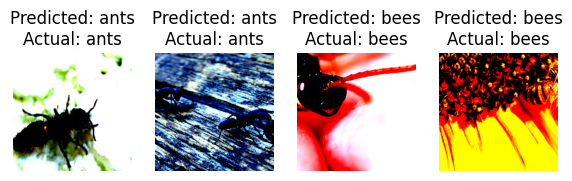

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


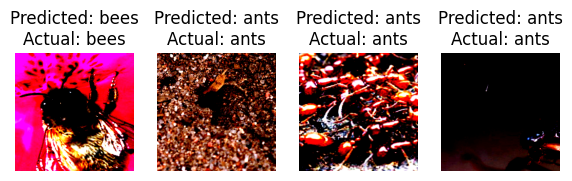

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


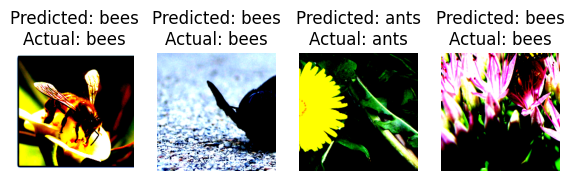

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


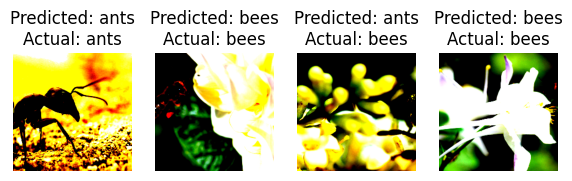

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


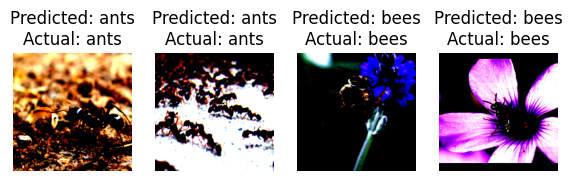

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


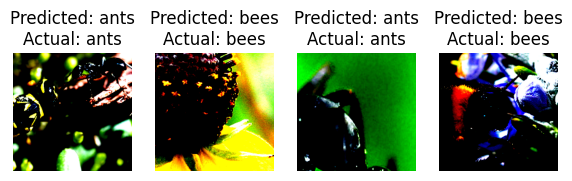

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


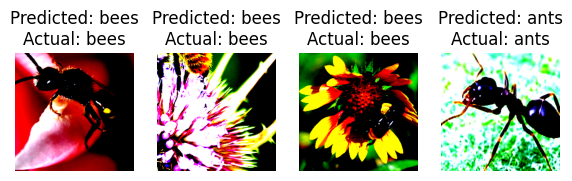

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


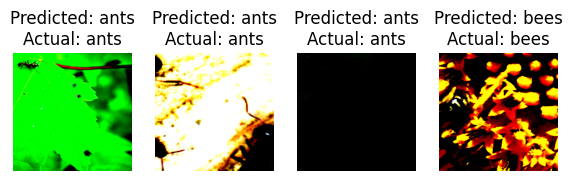

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


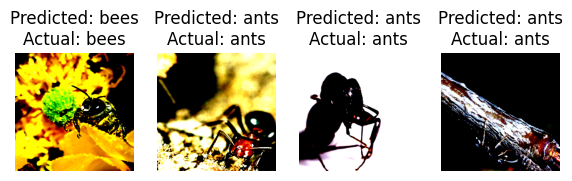

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


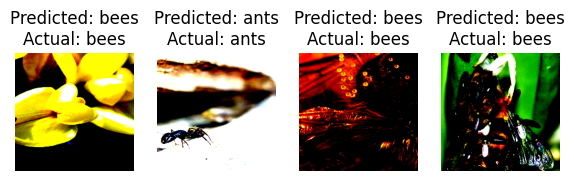

In [14]:
# TODO: напишим функцию, прогоняющую модель на нескольких примерах из валидационной выборки
# Отобразим картинки и предсказания

def visualize(model, dataloader, num_images=10):
    model.eval()
    class_names = dataloader.dataset.classes
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if i >= num_images:
                break
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            fig = plt.figure(figsize=(18, 6))
            for j in range(inputs.size(0)):
                plt.subplot(1, num_images, j+1)
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                plt.title(f'Predicted: {class_names[preds[j]]}\nActual: {class_names[labels[j].item()]}')
                plt.axis('off')
                
            plt.show()
            
visualize(model_ft, dataloaders['train'])